# Model evaluation

In this notebook we are obtaining the model predictions.

In [258]:
# Import libraries
import numpy as np
import pandas as pd

# SKlearn metric
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

# Pytorch forecasting
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer

import matplotlib.pyplot as plt
if not hasattr(np, 'float'):
    np.float = float

First, we need to read the data and construct the dataframe. The variable "n_months" can be modified to use different series lengths.

In [259]:
ckpt_path_3windows = "tft_results_logs/TFM_model_3windows/version_2/checkpoints/epoch=14-step=43815.ckpt"
df = pd.read_csv("tft_predictions_murcia_dataframe.csv", parse_dates=["time"])
# Make the location id as string
df["location_id"] = df["location_id"].astype(str)
# Put manually the lon and lat values of the location
df["lon"] = 0.5
df["lat"] = 37.5

n_months = 12
df = df.tail(n_months*30+5) # If the number of months is small consider tu sum 50 days (the encoder length)

We need to define the TimeSeriesDataSet and DataLoaders to get the predictions.

In [260]:
# Define the encoder and decoder lengths
min_encoder_length = 50
max_encoder_length = 50
min_prediction_length = 7
max_prediction_length = 7

# Define the variables groups
group_ids = ["location_id"]
target = "2t"
time_varying_known_reals = ["time_idx_norm", "year", "dayofyear_sin", "dayofyear_cos", "month_sin", "month_cos"]
time_varying_known_categoricals = ["season"]
time_varying_unknown_reals = ["2t", "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10", "PC11"]
time_varying_unknown_categoricals = [] # There is no unknown categoricals variables
static_reals = ["lat", "lon"]
static_categoricals = ["is_ocean", "location_id"]


# Now we create the TimeSeriesDataSet for the train data
tft_prediction_dataset = TimeSeriesDataSet(
    df,
    time_idx="time_idx",
    target=target,
    group_ids=group_ids,
    max_encoder_length=max_encoder_length,
    min_encoder_length=min_encoder_length,
    max_prediction_length=max_prediction_length,
    min_prediction_length=min_prediction_length,
    time_varying_known_reals=time_varying_known_reals,
    time_varying_known_categoricals=time_varying_known_categoricals,
    time_varying_unknown_reals=time_varying_unknown_reals,
    static_reals=static_reals,
    static_categoricals=static_categoricals,
    allow_missing_timesteps=True,
    target_normalizer=GroupNormalizer(groups=group_ids), 
    )

test_dataloader = tft_prediction_dataset.to_dataloader(train=False, batch_size=1)

tft_3windows = TemporalFusionTransformer.load_from_checkpoint(ckpt_path_3windows)

raw_predictions, x = tft_3windows.predict(test_dataloader, mode="raw", return_x=True)

# Map each time index to a date
time_map = dict(zip(df["time_idx"], df["time"]))

# For each batch, transform each time index into a real date
dates = []
for idx in range(len(raw_predictions.prediction)):
    decoder_time_idxs = x["decoder_time_idx"][idx].detach().cpu().numpy()
    decoder_dates = [pd.to_datetime(time_map[ti]) for ti in decoder_time_idxs]
    dates.extend(decoder_dates)  # extend (no append)

# Transform to array the dates
dates = pd.to_datetime(np.array(dates))

# Get the quantile predictions
pred_tensor = raw_predictions.prediction
pred_p10 = pred_tensor[:, :, 0].reshape(-1).numpy()
pred_median = pred_tensor[:, :, 1].reshape(-1).numpy()
pred_p90 = pred_tensor[:, :, 2].reshape(-1).numpy()

# Make a dataframe with all the predictions
df_preds = pd.DataFrame({
    "date": pd.to_datetime(dates),
    "pred_median": pred_median,
    "pred_p10": pred_p10,
    "pred_p90": pred_p90
})

# Sort by date and get the means of the predictions on each date
df_preds = df_preds.groupby("date").mean().reset_index()

/root/.pyenv/versions/tft-venv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/root/.pyenv/versions/tft-venv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


With the predictions we can plot them.

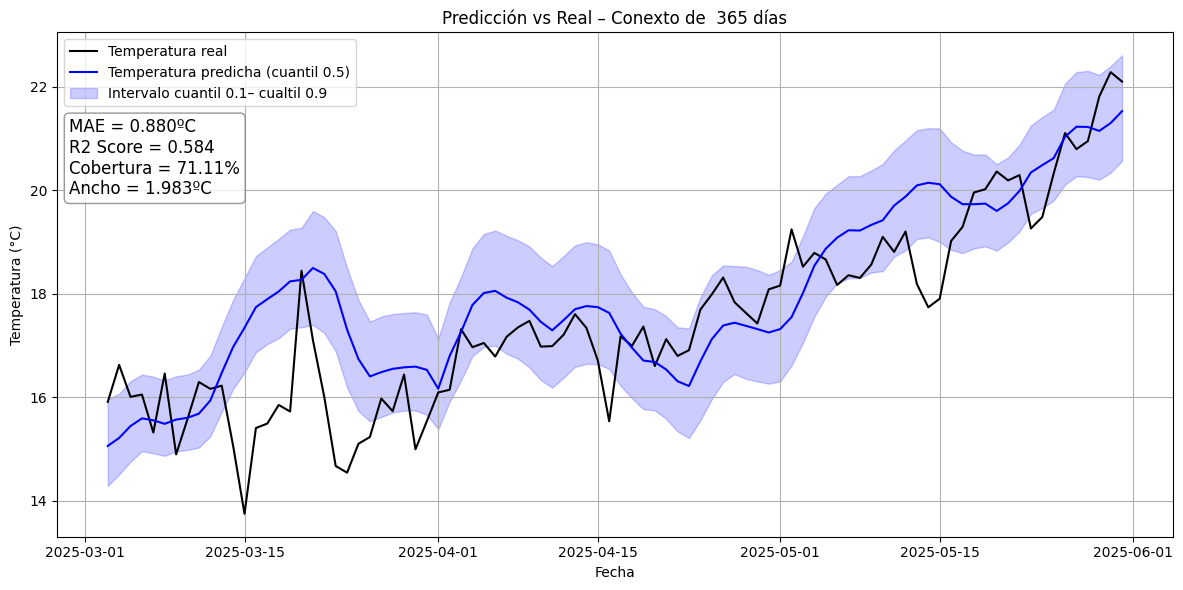

In [261]:
# Add to the dataframe the real values to compare and merge the dataframes
df_real = df[["time", "2t"]].drop_duplicates().rename(columns={"time": "date", "2t": "real"}).copy()
df_predvsreal = df_preds.merge(df_real, on="date", how="left")

# Define the plot time size
n_months_visual = 3
df_plot = df_predvsreal.tail(n_months_visual*30)

# Define the metrics of the predictions
MAE = mae(df_plot["real"], df_plot["pred_median"])
R2 = r2_score(df_plot["real"], df_plot["pred_median"])
def interval_metrics(y_true, q_low, q_high):
    in_interval = (y_true >= q_low) & (y_true <= q_high)
    coverage = np.mean(in_interval)*100  
    width = np.mean(q_high - q_low)
    return coverage, width

coverage, width = interval_metrics(df_plot["real"], df_plot["pred_p10"], df_plot["pred_p90"])

# Plot the predictions
plt.figure(figsize=(12,6))
plt.plot(df_plot["date"], df_plot["real"], label='Temperatura real', color='black')
plt.plot(df_plot["date"], df_plot["pred_median"], label='Temperatura predicha (cuantil 0.5)', color='blue')
plt.fill_between(df_plot["date"], df_plot["pred_p10"], df_plot["pred_p90"], color='blue', alpha=0.2, label='Intervalo cuantil 0.1– cualtil 0.9')
plt.legend(loc = "upper left")

plt.text(
    0.011, 0.83,               
    f"MAE = {MAE:.3f}ºC\nR2 Score = {R2:.3f} \nCobertura = {coverage:.2f}%\nAncho = {width:.3f}ºC",              
    transform=plt.gca().transAxes,  
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor='white', edgecolor='gray', alpha=0.8)
)

plt.title(f"Predicción vs Real – Conexto de  {len(df)} días")
plt.xlabel("Fecha")
plt.ylabel("Temperatura (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()
